<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

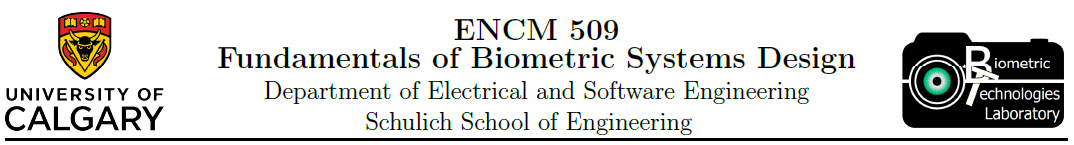

<center>
    <h1>Laboratory Experiment #5</h1>
    <h3>Fingerprint Biometrics - Part II: Matching</h3>
</center>

| Student name | UCID |
| -------------|----:|
| Rian Opperman | 30118288 |
|Mohammed Alshoura | 30126200|

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib as mpl

from scipy import ndimage as ndi

from sklearn.feature_extraction.image import extract_patches_2d

from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils_encm.blockproc import blockproc
from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.align2 import align2
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match
import multiprocessing as mp

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

#### Some auxiliary functitons

In [2]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

In [3]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

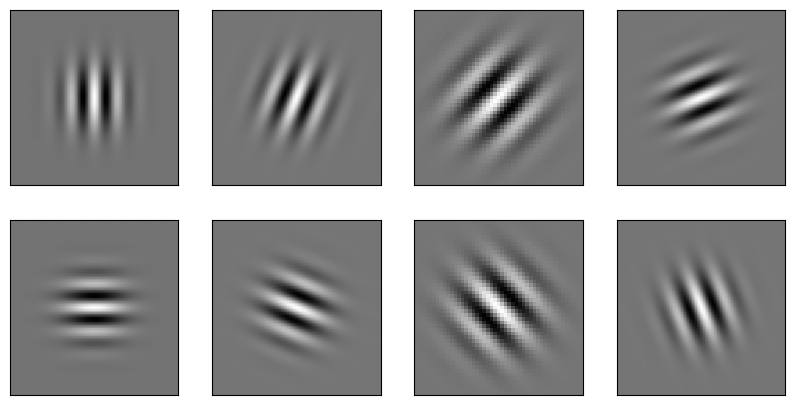

In [5]:
# +0.1 because python discart the last value
angle = np.arange(0, np.pi-np.pi/8+0.1, np.pi/8)
# filter size: x, y
xsize = 32; ysize = 32
# standard deviation of the gaussian envelope
dx = 8; dy = 8
# frequency
fq = 0.11

plt.figure(figsize=(10,5))

# filtering and feature extraction
for i,a in enumerate(angle):
    # build the filter
    gabor = np.real(gabor_kernel(fq, theta=a, sigma_x=dx, sigma_y=dy, n_stds=4))
    
    # show Gabor filters
    plt.subplot(2, 4, i+1)
    plt.imshow(gabor, cmap='gray', aspect='auto')
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

#### 3D representation of the Gabor filter

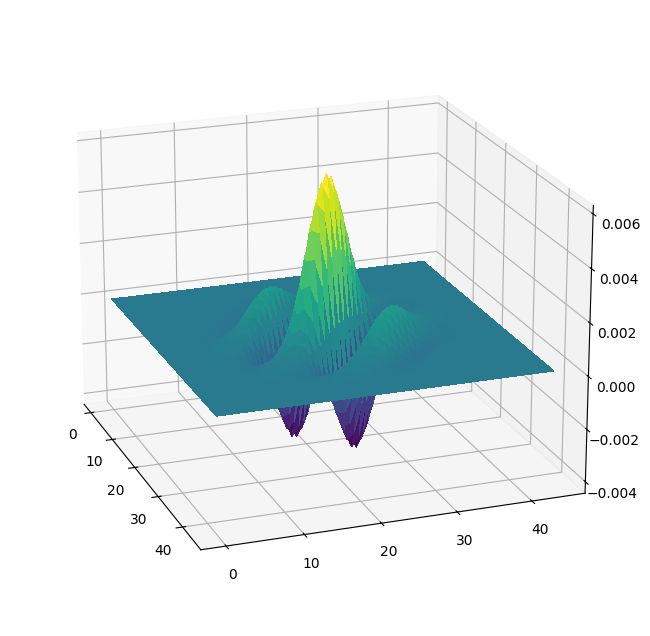

In [6]:
fi = gabor_template(img, angle=np.pi/4)

# Filter as a 3D function
fi_r, fi_c = fi.shape

X = np.arange(0, fi_c)
Y = np.arange(0, fi_r)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, fi, cmap=cm.viridis,
                       linewidth=0, antialiased=False)
ax.view_init(elev=20, azim=-20)

In [9]:
fi = gabor_template(img, angle=-np.pi/4)
img_f = gabor_filtering(img, fi)

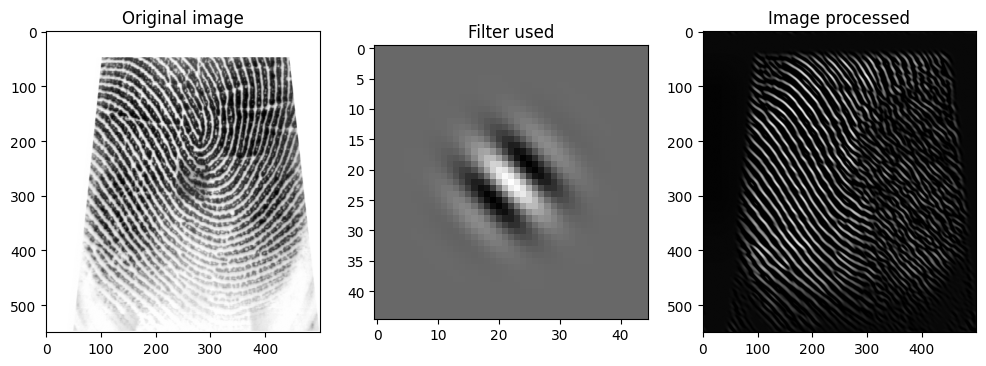

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(fi, cmap='gray'); plt.title('Filter used')
plt.subplot(1,3,3)
plt.imshow(img_f, cmap='gray'); plt.title('Image processed');

### Images from the `same` person

In [11]:
# both images HAVE to have the same size!!

im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/14.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

Score using Gabor features: 15.2020


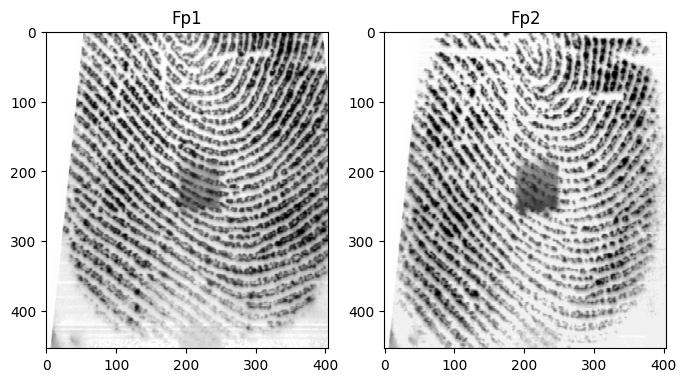

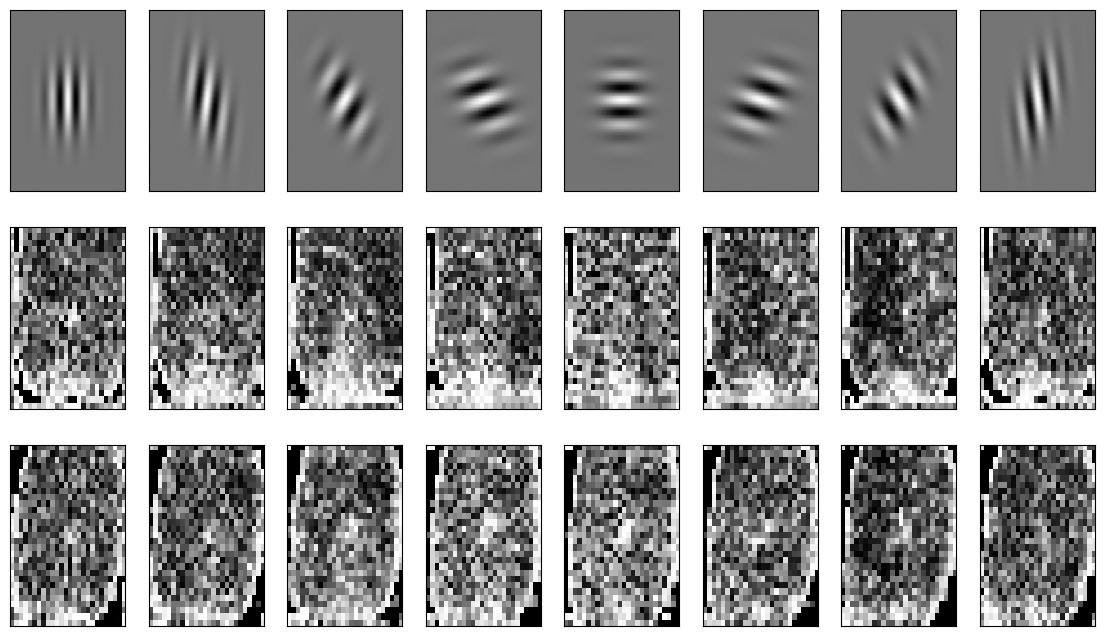

In [12]:
# if you don't want to see the plot, set the parameter: plot_res=False
score1 = MatchGaborFeat(im1, im2, plot_res=True)
print('Score using Gabor features: %.4f' % (score1))

### Images from two `different` people

In [13]:
# Subject 1
im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/14.bmp', as_gray=True))

# Subject 2
im4 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))

Score using Gabor features: 17.2868


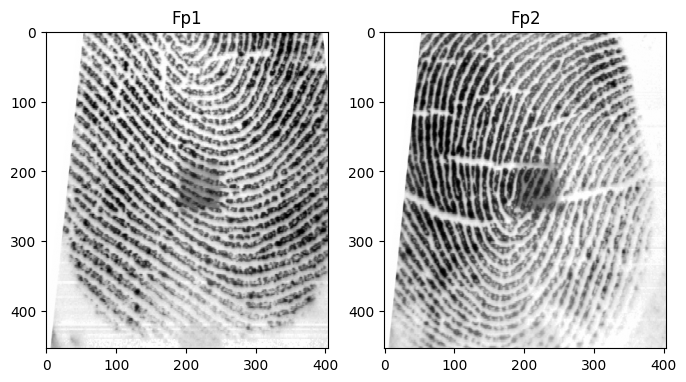

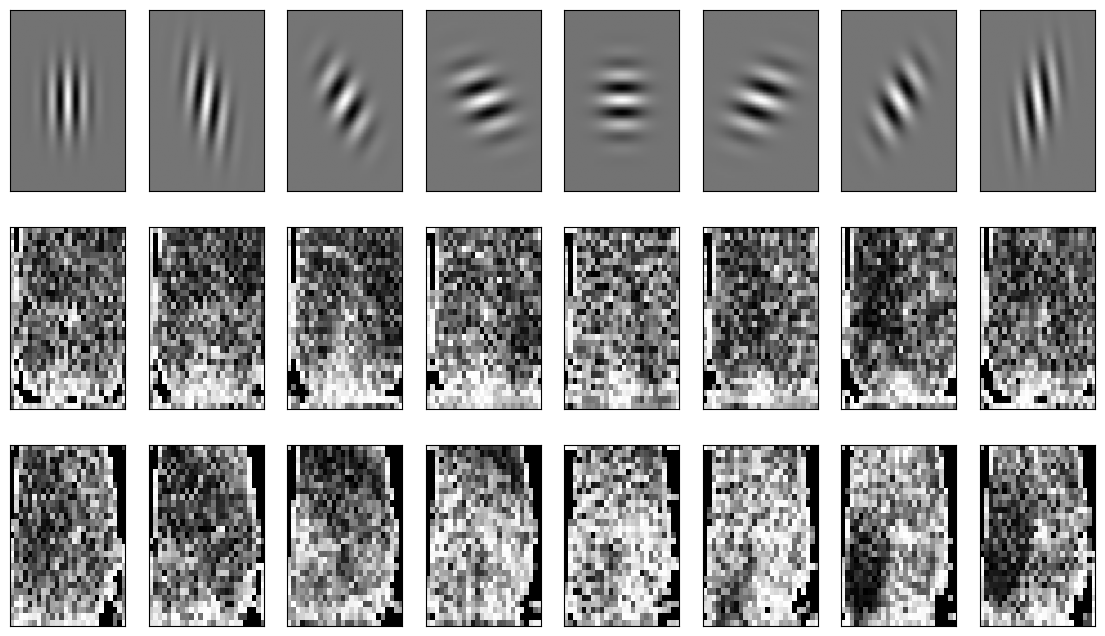

In [14]:
# if you don't want to see the plot, set the parameter: plot_res=False
score2 = MatchGaborFeat(im1, im4, plot_res=True)
print('Score using Gabor features: %.4f' % (score2))

## Introduction

The focus of the lab is to explore and investigate two different fingerprint matching algorithms, a minutiae based approach and a Gabor filter based approach. We will then discover and determine the key differences between these algorithms, as well as their strengths and weaknesses. We will also attempt to understand how a threshold score affects the matching of said fingerprints and how we can determine an optimum threshold for matching fingerprints which minimizes false positives, while keeping true positives high.

### Exercise 1

In [7]:
img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))

# Using angle = pi/4 & freq = 0.11
fi1 = gabor_template(img, angle=np.pi/4, freq=0.11)
fi2 = gabor_template(img, angle=np.pi/4, freq=0.22)
fi3 = gabor_template(img, angle=np.pi/8, freq=0.11)
fi4 = gabor_template(img, angle=np.pi/8, freq=0.22)

img_fi1 = gabor_filtering(img, fi1)
img_fi2 = gabor_filtering(img, fi2)
img_fi3 = gabor_filtering(img, fi3)
img_fi4 = gabor_filtering(img, fi4)

Text(0.5, 1.0, 'Angle = $\\pi/8$, Frequency = $0.22$')

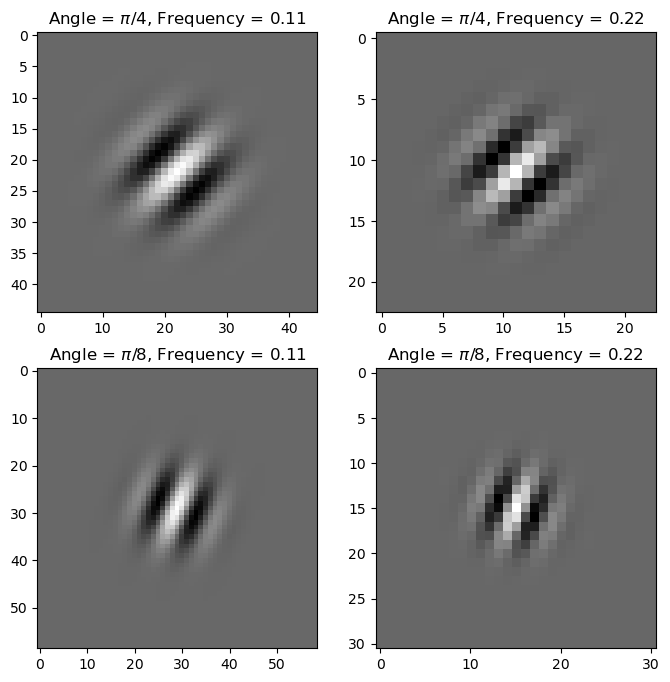

In [13]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(fi1, cmap='gray')
plt.title('Angle = $\\pi/4$, Frequency = $0.11$')
plt.subplot(2,2,2)
plt.imshow(fi2, cmap='gray')
plt.title('Angle = $\\pi/4$, Frequency = $0.22$')
plt.subplot(2,2,3)
plt.imshow(fi3, cmap='gray')
plt.title('Angle = $\\pi/8$, Frequency = $0.11$')
plt.subplot(2,2,4)
plt.imshow(fi4, cmap='gray');
plt.title('Angle = $\\pi/8$, Frequency = $0.22$')

Text(0.5, 1.0, 'Original image')

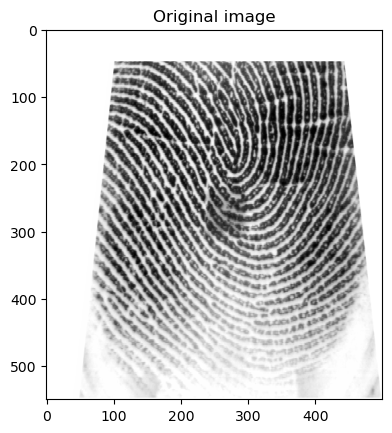

In [9]:
plt.imshow(img, cmap='gray')
plt.title('Original image')

Text(0.5, 1.0, 'Angle = $\\pi/8$, Frequency = $0.22$')

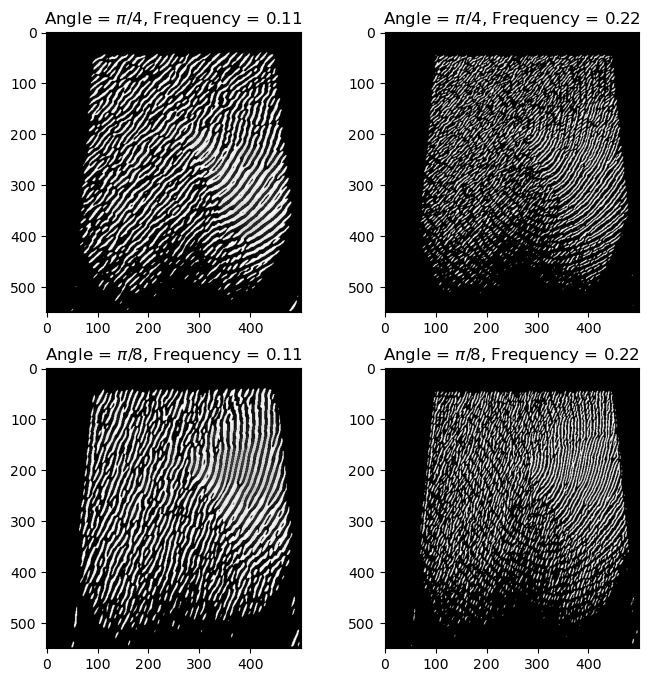

In [12]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(img_fi1, cmap='gray')
plt.title('Angle = $\\pi/4$, Frequency = $0.11$')
plt.subplot(2,2,2)
plt.imshow(img_fi2, cmap='gray')
plt.title('Angle = $\\pi/4$, Frequency = $0.22$')
plt.subplot(2,2,3)
plt.imshow(img_fi3, cmap='gray')
plt.title('Angle = $\\pi/8$, Frequency = $0.11$')
plt.subplot(2,2,4)
plt.imshow(img_fi4, cmap='gray')
plt.title('Angle = $\\pi/8$, Frequency = $0.22$')

### Analysis

The visual impact of changing the angle and frequency parameters of the Gabor Filter is it changes it's angle of focus. As can be seen above, when the angle decreases from $\pi/4$ to $\pi/8$, the total analysis angle of the Gabor filter grows, as evident by the top right of the fingerprint being clearer in the $\pi/8$ case than the $\pi/4$ case.

We can also see that by changing the frequency from $0.11$ to $0.22$ we have a sharper image. Usually a sharper image is better, but as can be seen above, when the sharpness is increased too much the image gains a lot of noise and becomes more indiscernable.

### Exercise 2

In [14]:
right_thumb_imgs = []
for i in range(1, 11):
    tmp = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/%d.bmp' % i, as_gray=True))
    right_thumb_imgs.append(fingerprint_processing(tmp, block_size=12, threshold=0.1))

In [15]:
print(len(right_thumb_imgs))

10


In [16]:
def align_and_match(probe_fingerprint, candidate_fingerprint, match_threshold):
    """
    Function to align the fingerprints and compute the matching score.
    """
    print("starting alignment\n")
    imSkeletonAlign, minutiaArrayAlign = align2(probe_fingerprint, candidate_fingerprint)
    
    candidate_fingerprint['imSkeletonAlign'] = imSkeletonAlign
    candidate_fingerprint['minutiaArrayAlign'] = minutiaArrayAlign
    
    print("finished alignment\n")
    score = match(probe_fingerprint, candidate_fingerprint, threshold2=match_threshold)

    return score

In [18]:
probe_fingerprint = right_thumb_imgs[0]
database_fingerprints = right_thumb_imgs[1:]

match_threshold = 6

minutiae_match_results_11 = []

for fingerprint in database_fingerprints:
    temp = align_and_match(probe_fingerprint, fingerprint, match_threshold)
    print('Score using minutiae features: %.4f' % (temp))
    minutiae_match_results_11.append(temp)

starting alignment

finished alignment



c:\Users\abual\Documents\ENCM509\Lab5\utils_encm\match.py:164: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(3)


number of matched minutiae: 294
distance total computed : 1238
number of minutiae in input image: 4430
number of minutiae in database image: 756
Score using minutiae features: 0.1134
starting alignment

finished alignment

number of matched minutiae: 266
distance total computed : 1150
number of minutiae in input image: 4248
number of minutiae in database image: 756
Score using minutiae features: 0.1063
starting alignment

finished alignment

number of matched minutiae: 159
distance total computed : 741
number of minutiae in input image: 3873
number of minutiae in database image: 756
Score using minutiae features: 0.0687
starting alignment

finished alignment

number of matched minutiae: 63
distance total computed : 285
number of minutiae in input image: 3294
number of minutiae in database image: 756
Score using minutiae features: 0.0311
starting alignment

finished alignment

number of matched minutiae: 188
distance total computed : 854
number of minutiae in input image: 4120
number of

In [15]:
# both images HAVE to have the same size!!
im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/7.bmp', as_gray=True))

Fp1 = fingerprint_processing(im1, block_size=12, threshold=0.1)
Fp2 = fingerprint_processing(im2, block_size=12, threshold=0.1)

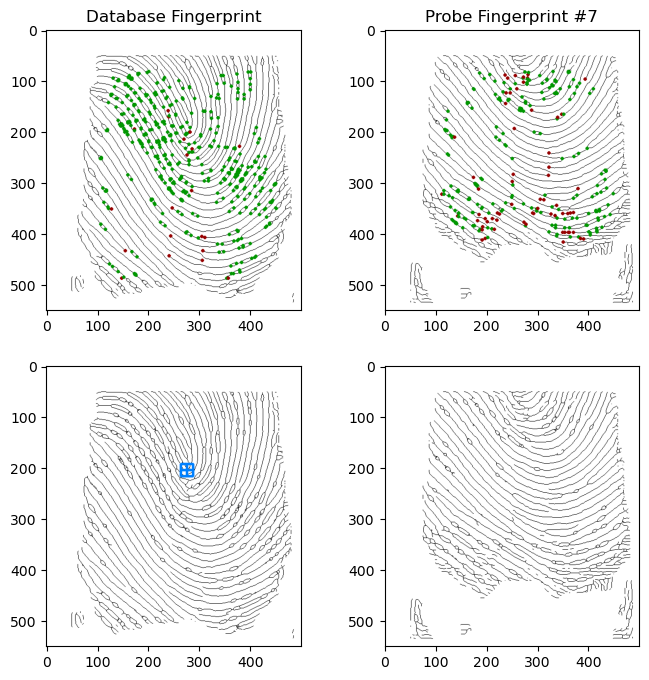

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(Fp1['minutiae_img'])
plt.title('Database Fingerprint')
plt.subplot(2,2,2)
plt.imshow(Fp2['minutiae_img'])
plt.title('Probe Fingerprint #7')
plt.subplot(2,2,3)
plt.imshow(Fp1['singularities_img'])
plt.subplot(2,2,4)
plt.imshow(Fp2['singularities_img']);

TP rate vs. FN rate = (0.89, 0.11)
TP rate vs. FN rate = (0.89, 0.11)
TP rate vs. FN rate = (0.78, 0.22)
TP rate vs. FN rate = (0.78, 0.22)
TP rate vs. FN rate = (0.56, 0.44)
TP rate vs. FN rate = (0.44, 0.56)
TP rate vs. FN rate = (0.33, 0.67)
TP rate vs. FN rate = (0.22, 0.78)
TP rate vs. FN rate = (0.22, 0.78)
TP rate vs. FN rate = (0.11, 0.89)


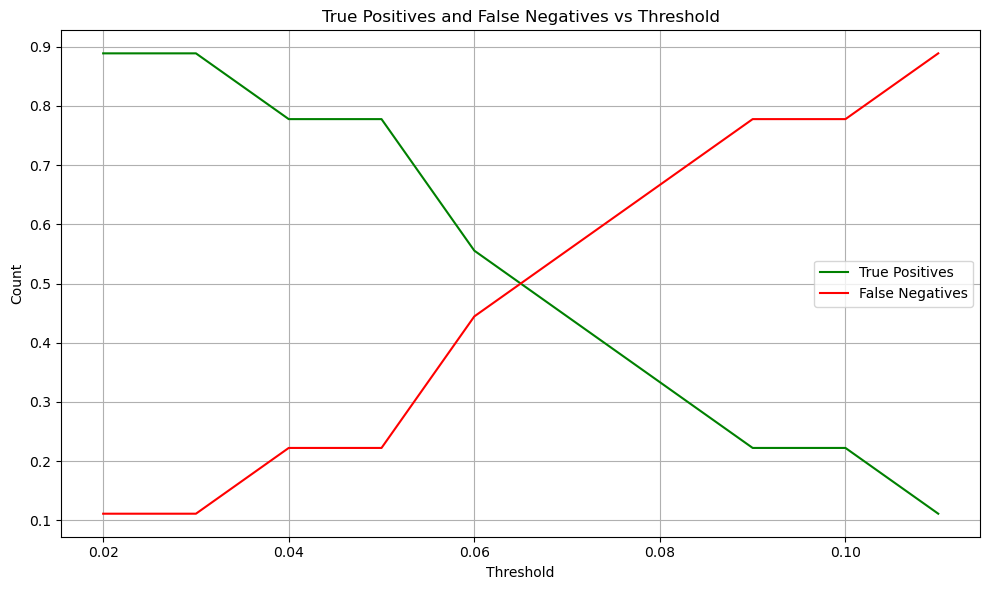

In [28]:
scores = [0.1134, 0.1063, 0.0687, 0.0311, 0.0771, 0.0, 0.0506, 0.0841, 0.0524 ]

thresholds = np.arange(0.02, 0.12, 0.01)
tp_count = []
fn_count = []

for threshold in thresholds:
    tp = [score for score in scores if score >= threshold]
    fp = [score for score in scores if score < threshold]
    tp_percent = len(tp) / len(scores)
    fn_percent = len(fp)/len(scores)
    print(f"TP rate vs. FN rate = ({tp_percent:.2f}, {fn_percent:.2f})")
    tp_count.append(tp_percent)
    fn_count.append(fn_percent)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, tp_count, 'g-', label='True Positives')
plt.plot(thresholds, fn_count, 'r-', label='False Negatives')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('True Positives and False Negatives vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Analysis

> *Note: The comparison number below refers to the comparison of the database fingerprint (fingerprint 1) and the probe fingerprint (comparison number + 1), i.e. comparison #2 is the comparison of fingerprint 1 to fingerprint 3.*

| Comparison #  | Matched Minutiae | Computed distance | Minutiae in probe | Minutiae in database | Score |
| :-----------: | ----------------: | ----------------------: | ----------------: | -------------------: | ----: |
| 1 | 294 | 1238 | 4430 | 756 | 0.1134 |
| 2 | 266 | 1150 | 4248 | 756 | 0.1063 |
| 3 | 159 | 741 | 3873 | 756 | 0.0687 |
| 4 | 63 | 285 | 3294 | 756 | 0.0311 |
| 5 | 188 | 854 | 4120 | 756 | 0.0771 |
| 6 | 0 | 0 | 0 | 756 | 0.0000|
| 7 | 128 | 643 | 4306 | 756 | 0.0506 |
| 8 | 197 | 896 | 3931 | 756 | 0.0841 |
| 9 | 139 | 602 | 4552 | 756 | 0.0524 |

| Comparison #  | Score | Match type<br>(threshold = 0.04) |
| :-----------: | ----: | :---: |
| 1 | 0.1134 | TP |
| 2 | 0.1063 | TP |
| 3 | 0.0687 | TP |
| 4 | 0.0311 | **FN** |
| 5 | 0.0771 | TP |
| 6 | 0.0000| **FN** |
| 7 | 0.0506 | TP |
| 8 | 0.0841 | TP |
| 9 | 0.0524 | TP |

As can be seen from the graph above, depending on the chosen score threshold the amount of true positive (TP) and false negative (FN) matches fluctuates from (0.89 TP rate, 0.11 FN rate) to (0.11 TP rate, 0.89 FN rate) using a threshold range of 0.02 - 0.12 with a step amount of 0.01. We can see that if we choose a very low threshold we can have a very high TP rate (TPR) with low FN rate (FNR), however we cannot get a TPR of 1 as we have comparison with a matching score of 0.0. Conversely, if we choose a very high threshold we get a very low TPR and a high FNR. This threshold choice remains arbitrary however without another set of impostor prints to compare to, which will help determmine the optimal threshold for a high TPR and low FNR.

As well, we can see that one of our fingerprints (fingerprint 7, comparison #6) has a match score of 0. When viewing the image, we can see that compared to our database print it is vastly different, which results in a very difficult, if not impossible, scenario where we cannot match the fingerprint based on minuatiae, as no minutiae are in the same position between the two fingerprints.

### Excercise 3

In [ ]:
right_thumb_imgs = []
for i in range(1, 11):
    right_thumb_imgs.append(img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/%d.bmp' % i, as_gray=True)))

In [29]:
def parallel_gabor_matching(probe_fingerprint, database_fingerprints):
    """
    Function to parallelize the fingerprint matching process.
    """
    num_processes = min(mp.cpu_count(), len(database_fingerprints))  # Limit processes to available cores
    with mp.Pool(processes=num_processes) as pool:
        results = pool.starmap(MatchGaborFeat, [(probe_fingerprint, fp, False) for fp in database_fingerprints])
    
    return results

probe_fingerprint = right_thumb_imgs[0]
database_fingerprints = right_thumb_imgs[1:]

# Run parallel fingerprint matching
gabor_match_results = parallel_gabor_matching(probe_fingerprint, database_fingerprints)

# Print the results
for result in gabor_match_results:
    print('Score using Gabor features: %.4f' % (result))

Score using Gabor features: 13.0024
Score using Gabor features: 13.1814
Score using Gabor features: 15.8798
Score using Gabor features: 13.7691
Score using Gabor features: 14.0760
Score using Gabor features: 16.8411
Score using Gabor features: 13.8880
Score using Gabor features: 14.0713
Score using Gabor features: 13.0218


TP rate vs. FN rate = (0.00, 1.00), threshold = 13.0
TP rate vs. FN rate = (0.22, 0.78), threshold = 13.1
TP rate vs. FN rate = (0.33, 0.67), threshold = 13.2
TP rate vs. FN rate = (0.33, 0.67), threshold = 13.3
TP rate vs. FN rate = (0.33, 0.67), threshold = 13.4
TP rate vs. FN rate = (0.33, 0.67), threshold = 13.5
TP rate vs. FN rate = (0.33, 0.67), threshold = 13.6
TP rate vs. FN rate = (0.33, 0.67), threshold = 13.7
TP rate vs. FN rate = (0.44, 0.56), threshold = 13.8
TP rate vs. FN rate = (0.56, 0.44), threshold = 13.9
TP rate vs. FN rate = (0.56, 0.44), threshold = 14.0
TP rate vs. FN rate = (0.78, 0.22), threshold = 14.1
TP rate vs. FN rate = (0.78, 0.22), threshold = 14.2
TP rate vs. FN rate = (0.78, 0.22), threshold = 14.3
TP rate vs. FN rate = (0.78, 0.22), threshold = 14.4
TP rate vs. FN rate = (0.78, 0.22), threshold = 14.5
TP rate vs. FN rate = (0.78, 0.22), threshold = 14.6
TP rate vs. FN rate = (0.78, 0.22), threshold = 14.7
TP rate vs. FN rate = (0.78, 0.22), threshold 

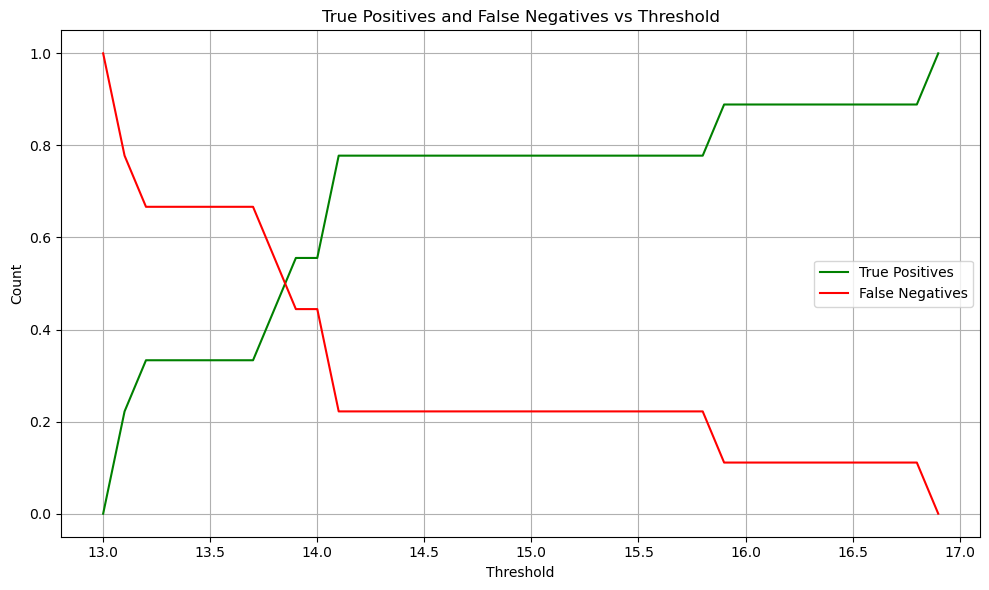

In [33]:
scores = [13.0024, 13.1814, 15.8798, 13.7691, 14.0760, 16.8411, 13.8880, 14.0713, 13.0218]

thresholds = np.arange(13, 17, 0.1)
tp_count = []
fn_count = []

for threshold in thresholds:
    tp = [score for score in scores if score <= threshold]
    fp = [score for score in scores if score > threshold]
    tp_percent = len(tp) / len(scores)
    fn_percent = len(fp)/len(scores)
    print(f"TP rate vs. FN rate = ({tp_percent:.2f}, {fn_percent:.2f}), threshold = {threshold:.1f}")
    tp_count.append(tp_percent)
    fn_count.append(fn_percent)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, tp_count, 'g-', label='True Positives')
plt.plot(thresholds, fn_count, 'r-', label='False Negatives')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('True Positives and False Negatives vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

> *Note: The comparison number below refers to the comparison of the database fingerprint (fingerprint 1) and the probe fingerprint (comparison number + 1), i.e. comparison #2 is the comparison of fingerprint 1 to fingerprint 3.*

| Comparison #  |  Score | Match type<br>(threshold = 16.5)
| :-----------: |  ----: | :--: |
| 1 | 13.0024 |  TP |
| 2 | 13.1814 |  TP |
| 3 | 15.8798 |  TP |
| 4 | 13.7691 | TP |
| 5 | 14.0760 | TP |
| 6 | 16.8411 | **FN** |
| 7 | 13.8880 | TP |
| 8 | 14.0713 | TP |
| 9 | 13.0218 | TP |

Comparing the Gabor score matching with the previous minutiae based matching, we can see that we arrive at a similar predicament where it is quite difficult to choose a threshold when we have no impostor dataset to compare with to help determine an optimum threshold. However, using a conservative threshold of 13.1 we arrive at a modest TPR of 0.89 and a FNR of 0.11, which will hopefully mitigate the amount of false positive if given an impostor fingerprint.

On a more comparative note, Gabor filter matching is faster than minutiae based matching as we do not need to comparitively check all detected minutiae in a fingerprint, but instead use a filter to detect how close a probe image is to a database image. This means that Gabor based matching is less sensitive to minute changes in fingerprint, as it doesn't check all minutiae, but if an image is "close enough". We can then say that when speed is crucial in implementations when accepting or rejecting a user, such as a smartphone fingerprint sensor, Gabor based matching should be used. Conversely, using a minutiae based approach may be better for a higher security scenario, where we must ensure that the individual in question is very close to the database fingerprint. 

As well, we can see that despite the different methods, we can arrive at a similar conclusion, e.g. both minutiae and Gabor based matching had a TPR and FNR of 0.89 & 0.11 respectively. In this regard, we can say that generally Gabor based matching is a good starting point for biometric applications and implementations.

### Exercise 4

In [12]:
# creating a database with 1 left thumb and 10 right thumb pictures
eleven_fingerprints = []
tmp = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
eleven_fingerprints.append(fingerprint_processing(tmp, block_size=12, threshold=0.1))
for i in range(1, 11):
    tmp = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/%d.bmp' % i, as_gray=True))
    eleven_fingerprints.append(fingerprint_processing(tmp, block_size=12, threshold=0.1))

In [13]:
print(len(eleven_fingerprints))

11


In [14]:
def align_and_match(probe_fingerprint, candidate_fingerprint, match_threshold):
    """
    Function to align the fingerprints and compute the matching score.
    """
    print("starting alignment\n")
    imSkeletonAlign, minutiaArrayAlign = align2(probe_fingerprint, candidate_fingerprint)
    
    candidate_fingerprint['imSkeletonAlign'] = imSkeletonAlign
    candidate_fingerprint['minutiaArrayAlign'] = minutiaArrayAlign
    
    print("finished alignment\n")
    score = match(probe_fingerprint, candidate_fingerprint, threshold2=match_threshold)

    return score

def parallel_minutiae_matching(probe_fingerprint, database_fingerprints, match_threshold):
    """
    Function to parallelize the fingerprint matching process.
    """
    num_processes = min(mp.cpu_count(), len(database_fingerprints))  # Limit processes to available cores
    
    # Use multiprocessing to parallelize the align_and_match function
    with mp.Pool(processes=num_processes) as pool:
        results = pool.starmap(align_and_match, [(probe_fingerprint, fp, match_threshold) for fp in database_fingerprints])
    
    return results

In [15]:
tmp = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/2.bmp', as_gray=True))
probe_fingerprint = fingerprint_processing(tmp, block_size=12, threshold=0.1)
database_fingerprints = eleven_fingerprints

# Run parallel fingerprint matching
match_threshold = 6
# minutiae_match_results = parallel_minutiae_matching(probe_fingerprint, database_fingerprints, match_threshold)


# # Print the results
# for result in minutiae_match_results:
#     print('Score using minutiae features: %.4f' % (result))

minutiae_match_results_11 = []

for fingerprint in database_fingerprints:
    temp = align_and_match(probe_fingerprint, fingerprint, match_threshdatabaseold)
    print('Score using minutiae features: %.4f' % (temp))
    minutiae_match_results_11.append(temp)

starting alignment



c:\Users\abual\Documents\ENCM509\Lab5\utils_encm\align2.py:49: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(3)


finished alignment



c:\Users\abual\Documents\ENCM509\Lab5\utils_encm\match.py:164: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(3)


number of matched minutiae: 256
distance total computed : 1188
number of minutiae in input image: 4571
number of minutiae in database image: 839
Score using minutiae features: 0.0946
starting alignment

finished alignment

number of matched minutiae: 170
distance total computed : 765
number of minutiae in input image: 3821
number of minutiae in database image: 839
Score using minutiae features: 0.0730
starting alignment

finished alignment

number of matched minutiae: 171
distance total computed : 752
number of minutiae in input image: 3821
number of minutiae in database image: 839
Score using minutiae features: 0.0734
starting alignment

finished alignment

number of matched minutiae: 188
distance total computed : 870
number of minutiae in input image: 4126
number of minutiae in database image: 839
Score using minutiae features: 0.0757
starting alignment

finished alignment

number of matched minutiae: 279
distance total computed : 1288
number of minutiae in input image: 6694
number o

In [17]:
temp = align_and_match(probe_fingerprint, database_fingerprints[7], match_threshold)
print('Score using minutiae features: %.4f' % (temp))

starting alignment

finished alignment

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 839
Score using minutiae features: 0.0000


### Analysis

> *Note: The comparison number below refers to the comparison of the database fingerprint (left thumb, overall fingerprint 1) and the probe fingerprint (comparison number), i.e. comparison #2 is the comparison of overall fingerprint 1, the left thumb, to overall fingerprint 2, right thumb, fingerprint 1.*

| Comparison #  |  Score |
| :-----------: |  ----: |
| **1** | **0.0946** |
| 2 | 0.0730 |
| 3 | 0.0734 |
| 4 | 0.0757 |
| 5 | 0.0741 |
| 6 | 0.0723 |
| 7 | 0.0512 |
| 8 | 0.0000|
| 9 | 0.0598 |
| 10 | 0.0523 |
| 11 | 0.0490 |

| Comparison #  |  Score |  Match type<br>(threshold = 0.0946) |
| :-----------: |  ----: |  :---: |
| 1 | 0.0946 | **TP** |
| 4 | 0.0757 | TN |
| 5 | 0.0741 | TN |
| 3 | 0.0734 | TN |
| 2 | 0.0730 | TN |
| 6 | 0.0723 | TN |
| 9 | 0.0598 | TN |
| 10 | 0.0523| TN |
| 7 | 0.0512 | TN |
| 11 | 0.0490 | TN |
| 8 | 0.0000 | TN |

When using the ranking based approach, where we sort the scores, and using the database fingerprint (left thumb, fingerprint 1), we can see that we have a true match at the top when matching the left thumb with itself. Thus, our threshold score is 0.0946, and we end up with 1 TP and the rest are TN, as the threshold determined fingerprint 1, the left thumb, to be a match for the database fingerprint, fingerprint 1.

From this we can see that the ranking based approach can help us in determining an optimal threshold for comparing fingerprints, and in our case provided us with a threshold which results in a TPR of 1, as there where no false positive matches. However, it is worth noting this may not always be the case, as sometimes the dataset or matching algorithm can give the true fingerprint a lower score than an impostor fingerprint.

## Conclusion

In conclusion, this lab provided a deeper understanding of fingerprint matching, as well as the processing used in matching a fingerrpint, by applying a minutiae and Gabor filter based matching algorithm. From this lab we gained a deeper understanding between the two matching algorithms and the pros and cons between them, such as the processing speed and sensitivity to minute differences between fingerprints. We also investigated a ranking based approach for matching fingerprints, which in our case resulted in an accurate threshold for matching fingerprints.